In [148]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt

import cv2 
from src.dataset import DspritesDataset, get_dataloaders_2element
from src.networks import MAGANet  # Replace with your actual model import
from src.args import Args


In [149]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH ="../outputs/run_prod_maga/seed_1_240320250829/models/model_2element.pth"

In [150]:
def visualize_image_output(output, name):
    
    if isinstance(output, tuple):
        output = output[0]

    if output.dim() == 4:  # [B, C, H, W]
        plt.figure(figsize=(15, 3))
        num_channels = min(5, output.size(1))  # Show up to 5 channels
        for i in range(num_channels):
            plt.subplot(1, num_channels, i + 1)
            plt.imshow(output[0, i].cpu().detach().numpy(), cmap='gray')
            plt.title(f'{name} Ch{i}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Cannot visualize {name}: unexpected shape {output.shape}")

In [151]:
def visualise_latents_traversals(model, x1, x2, save_file='traversals.gif'):
    # Get the base latent vector z
    with torch.no_grad():
        base_z, mu1, logvar1, _, _ = model.encoder(x1, x2)

    # Define traversal parameters with modified pattern:
    # 0 -> +delta -> -delta -> 0
    delta = 2.0    # Range of traversal
    
    # Create the steps sequence: 0 -> +delta -> -delta -> 0
    steps_up = np.linspace(0, delta, 25)  # From original to +delta
    steps_down = np.linspace(delta, -delta, 50)  # From +delta to -delta
    steps_back = np.linspace(-delta, 0, 25)  # From -delta back to original
    steps = np.concatenate([steps_up, steps_down, steps_back])
    num_steps = len(steps)  # Total number of steps in the sequence

    # Create directory for saving GIFs
    os.makedirs('traversals', exist_ok=True)

    # Create a list to hold the generated images for all components
    all_generated_images = []

    # Prepare the ground truth and varying images with labels
    gt_image = x1.cpu().numpy()[0, 0, :, :]  # Assuming x1 is [1, C, H, W]
    varying_image = x2.cpu().numpy()[0, 0, :, :]  # Assuming x2 is [1, C, H, W]
    gt_image = (gt_image * 255).astype(np.uint8)
    varying_image = (varying_image * 255).astype(np.uint8)

    # Add a white boundary around the ground truth and varying images
    gt_image = np.pad(gt_image, pad_width=5, mode='constant', constant_values=255)
    varying_image = np.pad(varying_image, pad_width=5, mode='constant', constant_values=255)

    # Perform latent traversal for each component
    latent_dim = base_z.size(1)
    for i in range(latent_dim):
        # Generate modified z vectors for component i
        z_traversals = []
        for step in steps:
            z_mod = base_z.clone()
            z_mod[0, i] = base_z[0, i] + step  # Modify i-th component
            z_traversals.append(z_mod)
        z_traversals = torch.cat(z_traversals, dim=0)  # Shape: [num_steps, latent_dim]

        x_pivots = x1.repeat(num_steps, 1, 1, 1)  # Repeat x_pivot for num_steps times

        # Generate images from modified z vectors
        with torch.no_grad():
            generated_images = model.decoder(z=z_traversals, x1=x_pivots)  # Shape: [num_steps, 1, H, W]

        # Convert tensors to numpy arrays for visualization
        generated_images = generated_images.cpu().numpy()  # [num_steps, 1, H, W]
        generated_images = generated_images[:, 0, :, :]    # [num_steps, H, W]

        # Prepare images for GIF (scale to [0, 255] and convert to uint8)
        images = [(img * 255).astype(np.uint8) for img in generated_images]

        # Add a white boundary around each generated image
        bordered_images = []
        for img in images:
            bordered_img = np.pad(img, pad_width=5, mode='constant', constant_values=255)  # Add a 5-pixel white border
            bordered_images.append(bordered_img)
        
        # Append the bordered images for this component to the all_generated_images list
        all_generated_images.append(bordered_images)

    # Create a single image for all components including ground truth and varying images
    final_images = []
    for step in range(num_steps):
        # Concatenate images for each step horizontally
        component_images = [all_generated_images[i][step] for i in range(latent_dim)]
        combined_image = np.concatenate(component_images, axis=1)  # This is 2D: [H, W_combined]
        
        # Stack GT and varying images to have the same number of dimensions as combined_image
        final_row = np.concatenate([gt_image, combined_image, varying_image], axis=1)
        
        # Create label areas with proper dimensions
        h = final_row.shape[0]  # Height of the combined image
        label_gt = np.full((h, 50), 255, dtype=np.uint8)  # White label background
        label_varying = np.full((h, 50), 255, dtype=np.uint8)  # White label background
        
        # Add the labels to the image
        final_row_with_labels = np.concatenate([label_gt, final_row, label_varying], axis=1)
        
        # Add text labels
        label_img = final_row_with_labels.copy()
        cv2.putText(label_img, 'Pivot', (0, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0), 2, cv2.LINE_AA)
        cv2.putText(label_img, 'GT', (label_img.shape[1] - 45, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0), 2, cv2.LINE_AA)
        
        final_images.append(label_img)

    # Save the final combined GIF
    final_gif_path = os.path.join('traversals', save_file)
    imageio.mimsave(final_gif_path, final_images, duration=0.05)  # 0.05s per frame for smoother animation
    print(f"Saved combined GIF at {final_gif_path}")

In [152]:
# Load the model

args  = Args(file="../data/configs/default.yaml")
model = MAGANet(args).to(device)  # Adjust parameters as per your model
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

MAGANet(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
    )
    (fc): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=20, bias=True)
    )
  )
  (decoder): FlowNet(
    (affine): Affine(
      (fc_M): Linear(in_features=10, out_features=4096, bias=True)
    )
    (flow_modules): Sequential(
      (0): FlowModule(
        (squeeze): SqueezeLayer()
        (flow_steps): Sequential(
          (0): FlowStep(
            (act_norm): ActNorm()
  

In [153]:
single_output = False
# Load dataset with the correct output format
train_data = DspritesDataset("../data/2d/train.npz", single_output=single_output)
test_data = DspritesDataset("../data/2d/test.npz", single_output=single_output)

# Choose the correct data loader function
if  "maga" in args.model_name:
    train_loader, test_loader = get_dataloaders_2element(
        train_data, test_data,
        batch_size=1
    )

    

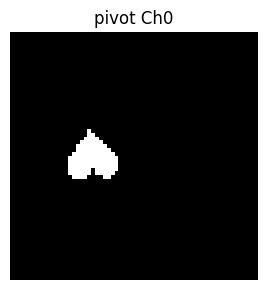

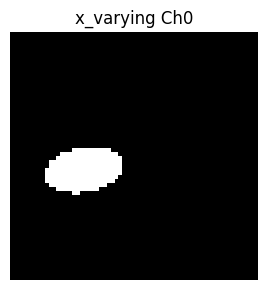

In [154]:
pairs = []

n_images = 10
for i, (x1, x2) in enumerate(train_loader):

    x_pivot, x_varying= x1.to(device), x2.to(device)
    pairs.append([x_pivot, x_varying])
    if i + 1 == n_images:
        break
    

# pairs = []
# image_ids = [4345, 43423, 34231, 123232]
# for i, (x1, x2) in enumerate(train_loader):
#     if i + 1 == max(image_ids):
#         break

#     if i in image_ids:
#         x_pivot, x_varying= x1.to(device), x2.to(device)
#         visualize_image_output(x_pivot, "pivot")

#         visualize_image_output(x_varying, "x_varying")

#         pairs.append([x_pivot, x_varying])

    

visualize_image_output(x_pivot, "pivot")

visualize_image_output(x_varying, "x_varying")


In [155]:

for i, (x1, x2) in enumerate(pairs):
    visualise_latents_traversals(model=model, x1=x1, x2=x2, save_file=f"traversals_{i}.gif")

Saved combined GIF at traversals/traversals_0.gif
Saved combined GIF at traversals/traversals_1.gif
Saved combined GIF at traversals/traversals_2.gif
Saved combined GIF at traversals/traversals_3.gif
Saved combined GIF at traversals/traversals_4.gif
Saved combined GIF at traversals/traversals_5.gif
Saved combined GIF at traversals/traversals_6.gif
Saved combined GIF at traversals/traversals_7.gif
Saved combined GIF at traversals/traversals_8.gif
Saved combined GIF at traversals/traversals_9.gif
